# Natural Language Processing with LSTM 
## Tweet Sentiment Analysis
---
Dataset: [kaggle/tweet_sentiment.csv](https://www.kaggle.com/datasets/kazanova/sentiment140)<br>
In this Note book we are going to Analyse Sentiments of Tweets using NLP and LSTM.


In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# preprocessing libraries
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import gensim


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# model evalution librabries
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

In [3]:
%matplotlib inline
sns.set_theme()
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
# importing dataset from drive
# saving dataframe in data varibale
data = pd.read_csv('/gdrive/MyDrive/py/tweet_sentiment.csv', encoding = 'latin', header=None)

In [6]:
# set columns
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

### About Dataset
> Dataset is downloaded from kaggle.

This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .<br><br>
It contains the following 6 fields:
* target: the polarity of the tweet (0 = negative, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)


In [7]:
# sample from data
data.sample(5)

,sentiment,id,date,query,user_id,text
604944,0,2222096418,Thu Jun 18 06:29:28 PDT 2009,NO_QUERY,DanielaAlmeida_,"FUCK LOVE, FUCK LIFE"
898016,4,1693507941,Sun May 03 22:46:40 PDT 2009,NO_QUERY,jtothenel,@smlimon in my defense I'd just luke to say th...
1297585,4,2004584910,Tue Jun 02 08:25:46 PDT 2009,NO_QUERY,Amymac81,cant believe how great the weather is
536328,0,2198362219,Tue Jun 16 15:58:27 PDT 2009,NO_QUERY,MrsLaBeouf,I dont know how to work this Help?
1256399,4,1997481108,Mon Jun 01 16:55:37 PDT 2009,NO_QUERY,HASKET,pretty please order our new CD! http://www.has...


## EDA

As we are going to work on `text` and `sentiment` fields, we can drop other useless fields to keep dataset simple.

In [8]:
# dropping least used cols
data.drop(columns=['id','date','query','user_id'], inplace=True)
data.sample(5)

,sentiment,text
1084081,4,is on the deck chillin with Erika and her cous...
1011118,4,Wainting for the day to come...
1022356,4,First look at the new Matt Collins T-Shirts! ...
1211904,4,"yay home time, time to change profile background"
820852,4,@MsPonita Little Men/Monsters will be tackled ...


In [9]:
# mapping sentiment
sentiment = {0:"Negative", 4:"Positive"}

def set_sentiment(senti):
  """
  set_sentiment(senti=sentiment)

  returns Negative for 0
          Positive for 4
  """
  return sentiment[senti]

data.sentiment = data.sentiment.apply(lambda x: set_sentiment(x))
data.sample(5)

,sentiment,text
346919,Negative,@erin82883 i don't know. i thought he was all ...
348737,Negative,@MLB_Updates I basically never trade. Too many...
1309406,Positive,@DoOrDie305 aww thanks sweet dreams.
1256478,Positive,feeling much better than before Working @ wir...
293900,Negative,"Oh, it's totally ok, just throw some hotdogs i..."


Now as we have decoded sentiment, now we will analyse it.<br>
We  will visualize and check if dataset is balanced or not

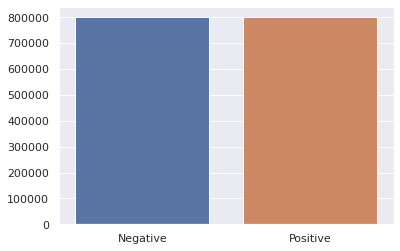

In [10]:
val_count = data.sentiment.value_counts()

sns.barplot(val_count.index, val_count.values);

Its good to see that our dataset is well balanced without any skewness.<br>
Now lets explore the data..

In [11]:
# printing random sample of 10
data.sample(10)

,sentiment,text
1352768,Positive,@mtnmissy Sure thing! Always willing to help a...
169394,Negative,Bugger. forgot I still have washing in my mach...
284616,Negative,@officialemily emilyyy. i cant think of a seco...
1099333,Positive,http://twitpic.com/690d1 - From the garden. Pr...
221514,Negative,@kc0219 ew
649510,Negative,@uhohhippos And I miss you too. I found someth...
1380877,Positive,Up early watching classic X Files reruns FTW
768111,Negative,Underestimated impact of listening to @amandap...
578511,Negative,@babymakes7 it's a damn shame someone as talen...
8688,Negative,@Edica sorry for sending that msg erica. LOL ...


Looks we need to work on dataset to make it clean. As it contain many characters that we wont require.

### Text Preprocessing
This is most important step in NLP models. before moving to train model our data should be less complex and contain only useful things. so for cleaning data we will use various preprocessing and cleaning method present in **NLTK**.
<br>
We will apply following preprocessing techniques:
* stemming
* stopwords removing
* removing special characters and links


In [12]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def text_prepocessing(text, stem=False):
  text = str(text).lower()
  text = re.sub(text_cleaning_re, ' ', text).strip()
  tokens = []
  for token in text.split():
      if token not in stop_words:
        if stem:
          tokens.append(stemmer.stem(token))
        else:
          tokens.append(token)
  return " ".join(tokens)

In [13]:
data['clean_text'] = data.text.apply(lambda x: text_prepocessing(x))

In [14]:
data.sample(10)

,sentiment,text,clean_text
1025790,Positive,@SamNUK Hey man no problem and thank you for...,hey man problem thank followfriday
1103151,Positive,@modernartrocks Bye Tam - we'll see you later ...,bye tam see later maybe
1054865,Positive,Visit the site to learn more about this exciti...,visit site learn exciting contest comment post...
923594,Positive,@jamishull hey! I thought you were not around ...,hey thought around anymore
262094,Negative,@TwoSharon cuz he needed sleep after baby girl...,cuz needed sleep baby girl decided maybe daddy...
502863,Negative,I miss my @Kykylie,miss kykylie
93748,Negative,"feeling absolutely crap, this cold sucks hope...",feeling absolutely crap cold sucks hope get we...
796759,Negative,says missed the artfire sneakers http://plurk...,says missed artfire sneakers
1421336,Positive,@DaddyPOV boxes and toys forgotten equals hour...,boxes toys forgotten equals hours novelty amp ...
1495002,Positive,@lynnftw Where have you been?! Great game las...,great game last night


**It is clean now, now lets see wordcloud visualization of it**

### Data Visualization
#### Positive Wordcloud

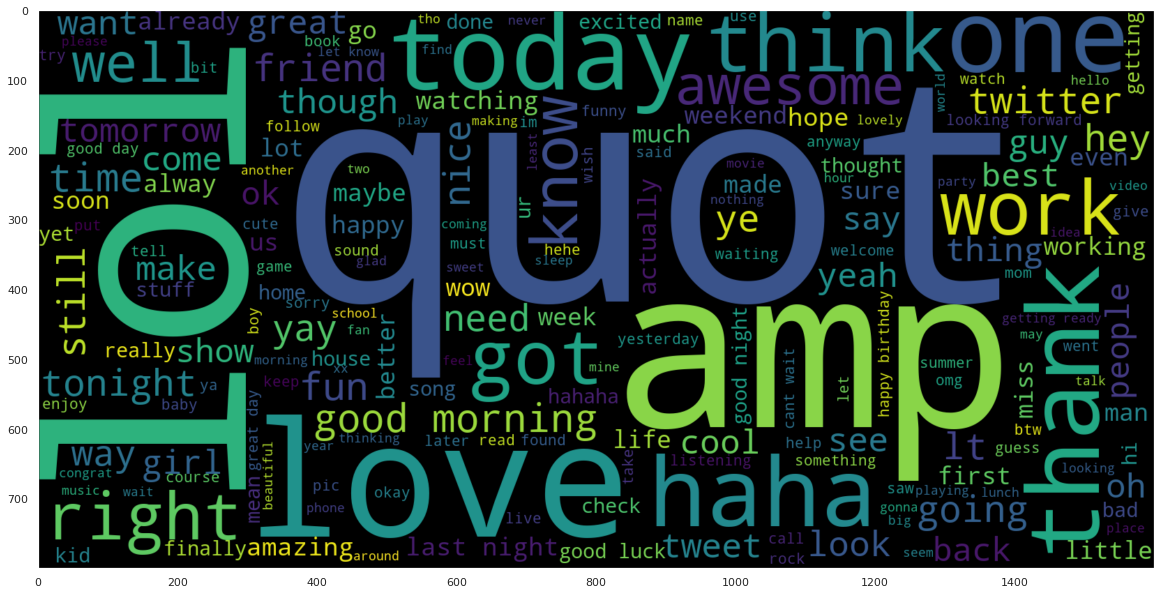

In [15]:
plt.figure(figsize=(20,20))
wc = WordCloud(width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 'Positive'].clean_text))
plt.imshow(wc, interpolation = 'bilinear')
plt.grid(False)

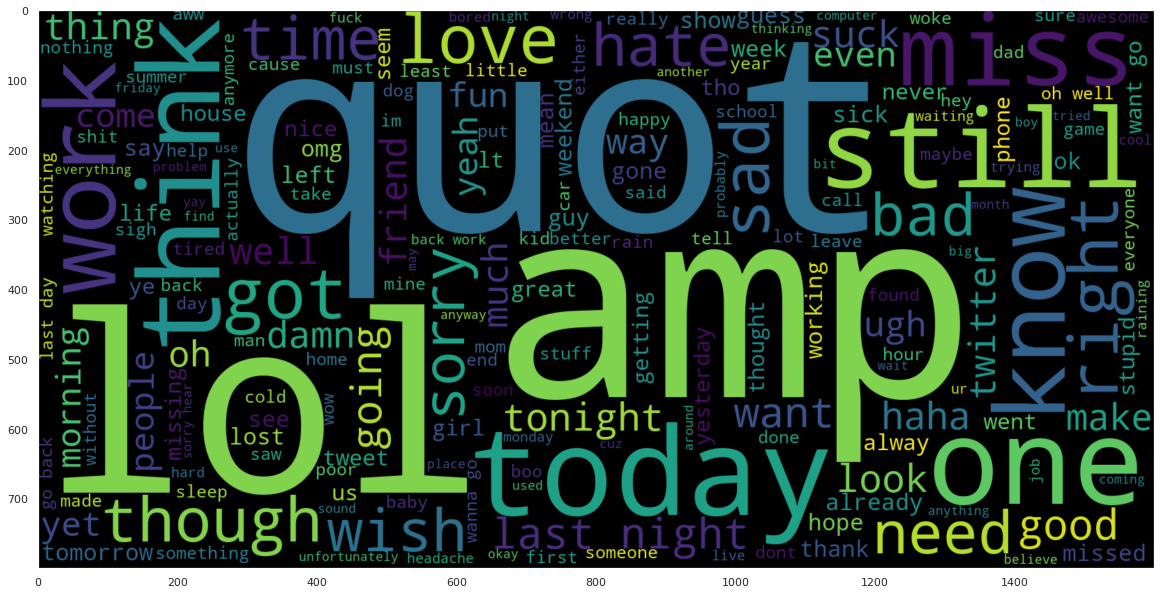

In [16]:
plt.figure(figsize=(20,20))
wc = WordCloud(width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 'Negative'].clean_text))
plt.imshow(wc, interpolation = 'bilinear')
plt.grid(False)

#### Tokenization

In [17]:
sentences =  []
for text in data['clean_text']:
  sentences.append(word_tokenize(text))

In [18]:
print("Length of Sentences we got: ", len(sentences))

Length of Sentences we got:  1600000


##### Now actually creating word 2 vec embedding

In [19]:
w2v_model=gensim.models.Word2Vec(sentences=sentences,size=300,window=10,min_count=1)

In [20]:
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(109295699, 115887360)

##### Now can try some things with word2vec embeddings. Thanks to Gensim ;)

In [21]:
# embedding of a particular word.
w2v_model.wv.get_vector('good')

array([ 0.35880402, -0.9574485 , -0.8370347 ,  0.05489685, -0.8835435 ,
       -0.85823256,  1.0861605 , -1.0259578 , -0.9506425 ,  1.1658456 ,
        1.034669  ,  0.9814415 , -1.2254527 ,  0.2928596 ,  0.320806  ,
       -0.5541706 , -0.72848713, -0.5978128 ,  1.0567552 ,  1.9705933 ,
        0.66741526, -0.21163772,  0.01398721,  0.2109231 ,  0.1783315 ,
       -1.3353956 ,  0.9063269 , -0.5379732 , -1.14572   , -0.9732532 ,
        0.43282163,  0.8560938 ,  0.18034005,  0.363103  , -0.17859976,
        0.23109727, -0.2779502 ,  0.09516384, -0.62320775,  0.43815407,
        0.23054591,  1.7020476 ,  0.886518  ,  0.23328444,  1.9822975 ,
       -0.40961805,  0.36979446, -0.60426885,  1.7924199 ,  0.27860284,
       -0.47517717, -1.1973351 ,  0.0270976 , -1.0146449 , -0.31515726,
        0.24530149, -0.5505834 , -0.7574849 ,  0.06187607, -0.09116252,
        0.04461828,  0.87097234, -1.3455279 ,  0.9756483 , -0.30605575,
        1.9101757 , -0.5827528 , -0.7076747 , -0.5758382 , -1.96

In [22]:
# total numberof extracted words.
vocab=w2v_model.wv.vocab
print(f'number of words are: {len(vocab)}')

number of words are: 335505


In [23]:
# top similar world to good
w2v_model.wv.most_similar('good')

[('great', 0.6204856634140015),
 ('bad', 0.5661447644233704),
 ('goood', 0.48319825530052185),
 ('gd', 0.46888425946235657),
 ('rough', 0.45383360981941223),
 ('tough', 0.44164392352104187),
 ('decent', 0.44031378626823425),
 ('shitty', 0.43922799825668335),
 ('excellent', 0.4376123547554016),
 ('gooood', 0.4372949004173279)]

##### Now creating a dictionary with words in vocab and their embeddings. This will be used when we will be creating embedding matrix (for feeding to keras embedding layer).

In [24]:
vocab_key=list(vocab.keys())

In [25]:
word_vec_dict={}
for word in vocab_key:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  335505


### PREPARING THE DATA FOR KERAS EMBEDDING LAYER
We need to find the maximum lenght of any document or review in our case. WE will pad all reviews to have this same length.This will be required by Keras embedding layer. Must check this kernel on Kaggle for a wonderful explanation of keras embedding layer.

In [26]:
# finding maximum length of text for padding
maxi = -1
for i in sentences:
  if(len(i)>maxi):
    maxi=len(i)
maxi

50

In [27]:
tok = Tokenizer()
tok.fit_on_texts(data['clean_text'])
encd_txt = tok.texts_to_sequences(data['clean_text'])

In [28]:
max_text_len=maxi  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [29]:
# now padding to have a amximum length of 1565
pad_txt= pad_sequences(encd_txt, maxlen=max_text_len, padding='post')
pad_txt.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 1565 words.

(1600000, 50)

Creating Embedding Matrix

In [30]:
# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

In [31]:
# checking.
print(embed_matrix[14])

[-8.34983289e-01 -1.43854666e+00 -7.99771905e-01 -6.45646453e-01
 -2.09298873e+00 -1.29860044e+00 -1.39684388e-02 -8.34778607e-01
 -7.08832502e-01  5.98325729e-01 -1.17233360e+00  1.30486822e+00
 -4.58995014e-01 -1.86484873e-01  8.48005235e-01 -9.60684896e-01
  1.20045280e+00 -3.09042931e-01 -1.54662144e+00 -3.55376959e-01
 -2.56079644e-01 -6.01126432e-01  5.50079882e-01 -3.47845167e-01
 -7.20249355e-01  1.33288968e+00  2.45264560e-01  8.74758124e-01
 -3.41137320e-01 -2.17300057e+00 -8.49604681e-02  4.21079546e-01
 -1.66415926e-02 -5.60012937e-01  1.27982938e+00  8.19240451e-01
 -1.05019793e-01 -1.10725904e+00  1.26709926e+00  1.52025795e+00
  9.88992095e-01 -1.01231229e+00 -9.31515634e-01 -1.21035028e+00
 -3.24267954e-01 -1.81993639e+00  2.49513298e-01 -1.87860191e-01
  1.26616836e+00  7.25065947e-01  5.79882801e-01 -5.89413166e-01
  7.73283988e-02 -4.24079269e-01 -4.06973571e-01  5.26286244e-01
  6.07301891e-01  2.94032007e-01 -1.17202020e+00  2.27978066e-01
 -6.20742142e-01 -6.81847

### Train Test Split
First we will encode our target field that is "sentiment"

In [32]:
encoder = LabelEncoder()
encoder.fit(data.sentiment.to_list())   # training encoder
y = encoder.transform(data.sentiment.to_list())  # transforming

In [33]:
X_train, X_test, y_train, y_test = train_test_split(pad_txt, y, test_size=0.2, random_state=40)


In [54]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (1280000, 50)
X_test: (320000, 50)
y_train: (1280000,)
y_test: (320000,)


### Building Model

In [48]:
model= Sequential()

In [49]:
# add layers
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_text_len, embeddings_initializer=Constant(embed_matrix), name='Embedding'))
model.add(LSTM(units=200,activation='relu', recurrent_dropout=0.2,name='LSTM'))
model.add(Dense(16,activation='relu', name='Dense1'))
#model.add(Dropout(0.50))
model.add(Dense(1,activation='sigmoid', name='OUTPUT'))  # sigmod for bin. classification.

Lets print model summary


In [50]:
# print summary of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 50, 300)           100652400 
                                                                 
 LSTM (LSTM)                 (None, 200)               400800    
                                                                 
 Dense1 (Dense)              (None, 16)                3216      
                                                                 
 OUTPUT (Dense)              (None, 1)                 17        
                                                                 
Total params: 101,056,433
Trainable params: 101,056,433
Non-trainable params: 0
_________________________________________________________________


In [51]:
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
# fitting model
model.fit(X_train, y_train, epochs=5, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/5
1280/1280 [==============================] - 215s 166ms/step - loss: 0.5317 - accuracy: 0.7109 - val_loss: 0.4443 - val_accuracy: 0.7911
Epoch 2/5
1280/1280 [==============================] - 212s 166ms/step - loss: 0.4252 - accuracy: 0.8027 - val_loss: 0.4306 - val_accuracy: 0.7987
Epoch 3/5
1280/1280 [==============================] - 211s 165ms/step - loss: 0.3813 - accuracy: 0.8280 - val_loss: 0.4500 - val_accuracy: 0.7934
Epoch 4/5
1280/1280 [==============================] - 211s 165ms/step - loss: 0.3354 - accuracy: 0.8500 - val_loss: 0.4682 - val_accuracy: 0.7934
Epoch 5/5
1280/1280 [==============================] - 212s 165ms/step - loss: 0.3050 - accuracy: 0.8630 - val_loss: 0.5274 - val_accuracy: 0.7900


In [53]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 169s 17ms/step - loss: 0.5274 - accuracy: 0.7900


[0.5273520946502686, 0.7900124788284302]